In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures

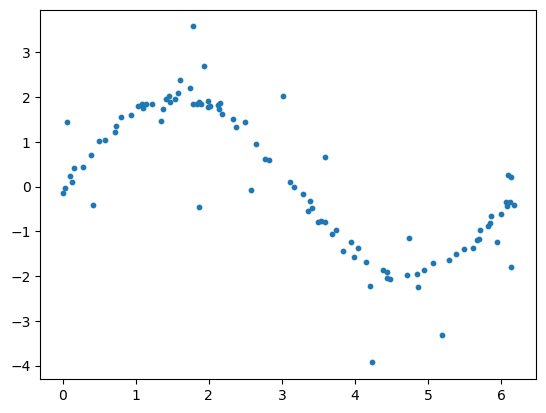

In [30]:
m = 100
X = 2*np.pi*np.random.rand(m)
y = 2*np.sin(X) + 0.1*np.random.randn(m)
# every 5 data points we will add an 'outlier'
y[::5] += 5*(0.5 - np.random.rand(int(m/5)))
plt.scatter(X, y, s=10)

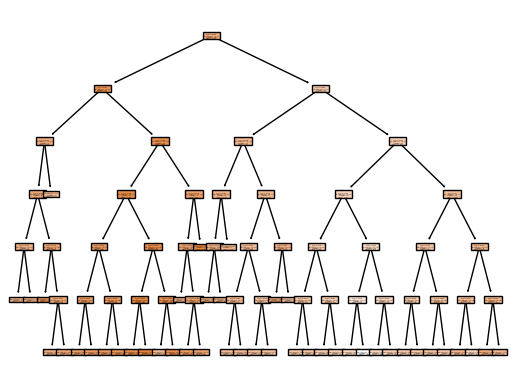

In [31]:
tree = DecisionTreeRegressor(max_depth=6)
tree.fit(X.reshape(-1, 1), y)
plot_tree(tree, filled=True)
plt.show()

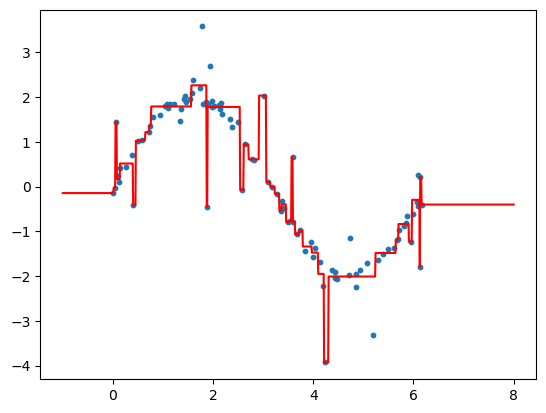

In [32]:
# plot the model
x_plot = np.linspace(-1, 8, 1000).reshape(-1, 1)
y_plot = tree.predict(x_plot)
plt.plot(x_plot, y_plot, c='r')
plt.scatter(X, y, s=10)
plt.show()

Remark 1: trees are very sensitive to outliers

Remark 2: trees are very bad at extrapolation

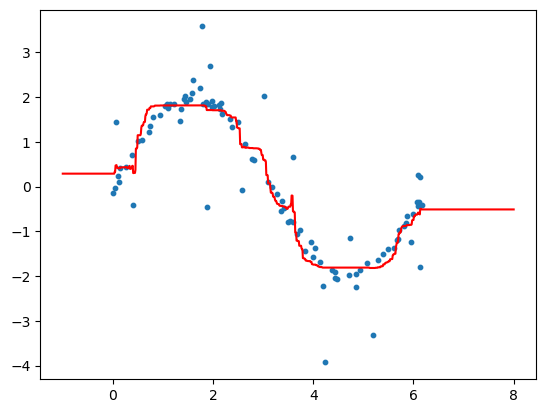

In [33]:
forest = RandomForestRegressor(n_estimators=200, max_depth=3)
forest.fit(X.reshape(-1, 1), y)
y_plot = forest.predict(x_plot)
plt.plot(x_plot, y_plot, c='r')
plt.scatter(X, y, s=10)
plt.show()

### Fremont Bridge revisited: lin reg vs random forest

In [34]:
fremont = pd.read_csv('../../Data/Fremont_Bridge_Bicycle_Counter.csv', index_col='Date', parse_dates=True)
fremont.columns = ['Total', 'East', 'West']
weather = pd.read_csv('../../Data/Seattle_weather_102012_082023.csv', index_col='DATE', parse_dates=True)

In [35]:
# compute daily traffic
fremont = fremont.resample('d').sum()

# day of the week/month/year/covid
fremont['day_of_week'] = fremont.index.dayofweek
fremont['month'] = fremont.index.month
fremont['year'] = fremont.index.year
# covid column: 0 = pre covid times; 1 = pos covid times
fremont['covid'] = 0
fremont.loc['03-01-2020':,'covid'] = 1 

# holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays('10-03-2012','08-31-2023')
fremont['holidays'] = pd.Series(1,index=holidays,name='holidays')
fremont.fillna(0,inplace=True)

# hours of daylight
def get_hoursdaylight(date):
    axis = np.radians(23.44) # tilt of Earth's axis
    latitude = np.radians(47.61) # Seattle's latidude 
    days = (date-pd.to_datetime('2000-12-31')).days
    m = (1 - np.tan(latitude)*np.tan(axis*np.cos(days*2*np.pi/365.25)))
    return 24*np.degrees(np.arccos(1-m))/180
fremont['hours_daylight'] = fremont.index.map(get_hoursdaylight)

# fix TAVG column
weather.TAVG.fillna(0.5*(weather.TMAX+weather.TMIN),inplace=True)

# add weather columns
fremont['PRCP'] = weather.PRCP
fremont['TAVG'] = weather.TAVG
fremont['SNOW'] = weather.SNOW
fremont['AWND'] = weather.AWND

fremont

,Total,East,West,day_of_week,month,year,covid,holidays,hours_daylight,PRCP,TAVG,SNOW,AWND
Date,,,,,,,,,,,,,
2012-10-03,3521.0,1760.0,1761.0,2,10,2012,0,0.0,11.863813,0.00,56.0,0.0,16.33
2012-10-04,3475.0,1708.0,1767.0,3,10,2012,0,0.0,11.804946,0.00,56.5,0.0,14.54
2012-10-05,3148.0,1558.0,1590.0,4,10,2012,0,0.0,11.746107,0.00,59.5,0.0,12.75
2012-10-06,2006.0,1080.0,926.0,5,10,2012,0,0.0,11.687302,0.00,60.5,0.0,11.41
2012-10-07,2142.0,1191.0,951.0,6,10,2012,0,0.0,11.628541,0.00,60.5,0.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27,2169.0,936.0,1233.0,6,8,2023,1,0.0,14.020464,0.00,72.0,0.0,6.26
2023-08-28,3027.0,1026.0,2001.0,0,8,2023,1,0.0,13.967394,0.00,66.0,0.0,6.71
2023-08-29,2767.0,842.0,1925.0,1,8,2023,1,0.0,13.913949,0.12,61.0,0.0,6.49


In [36]:
num_features = ['hours_daylight','year','PRCP','TAVG','SNOW','AWND','covid','holidays']
cat_features = ['day_of_week']


num_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
    ])

cat_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
    ])

pipe.fit(X,y)
fremont['pred_forest'] = pipe.predict(X)


feature_processor = ColumnTransformer(transformers=[
    ('num_processor',num_processor,num_features),
    ('cat_processor',cat_processor, cat_features),
])

pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('poly_features',PolynomialFeatures(degree=2)),
    ('reg',LinearRegression())
])

pipe

Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('num_processor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['hours_daylight', 'year',
                                                   'PRCP', 'TAVG', 'SNOW',
                                                   'AWND', 'covid',
                                                   'holidays']),
                                                 ('cat_processor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['day_of_week'])])),
                ('poly_features', PolynomialFeatures()),
                ('reg', LinearRegression())])

In [37]:
# feature matrix X, target vector y
y = fremont.Total
X = fremont[num_features+cat_features]

In [38]:
pipe.fit(X,y)
fremont['pred_lin_reg'] = pipe.predict(X)

In [39]:
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    #('poly_features',PolynomialFeatures(degree=2)),
    ('reg',RandomForestRegressor())
])

In [40]:
param_dict = {
    'reg__n_estimators': [100,200,300],
    'reg__max_depth': [2,5,8],
    'reg__min_samples_split': [2,4,8,16],
    'reg__min_samples_leaf': [1,2,4,8],
}

grid = GridSearchCV(pipe, param_grid=param_dict, cv=5, n_jobs=-1)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
fremont['pred_forest'] = grid.predict(X)

{'reg__max_depth': 8, 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 2, 'reg__n_estimators': 200}
0.7433814194306914


In [43]:
best_forest = grid.best_estimator_
fremont['pred_forest'] = best_forest.predict(X)

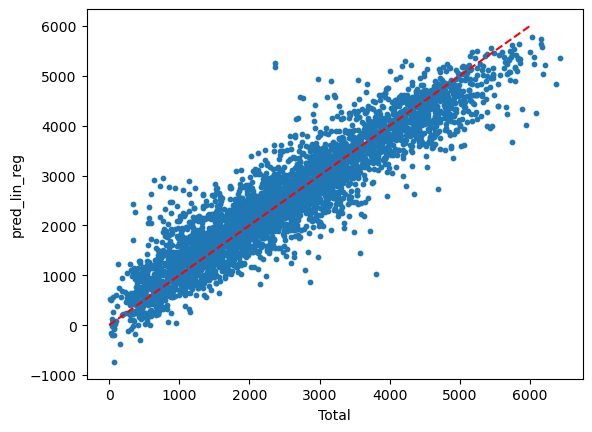

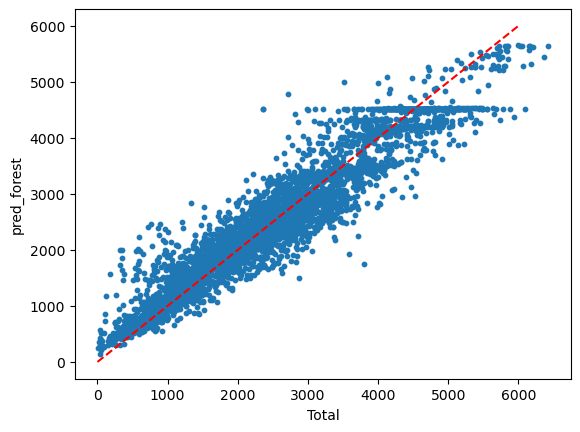

In [46]:
fremont.plot.scatter(x='Total',y='pred_lin_reg',s=10)
plt.plot([0,6000],[0,6000],'r--')
fremont.plot.scatter(x='Total',y='pred_forest',s=10)
plt.plot([0,6000],[0,6000],'r--')
plt.show()

<Axes: xlabel='Date'>

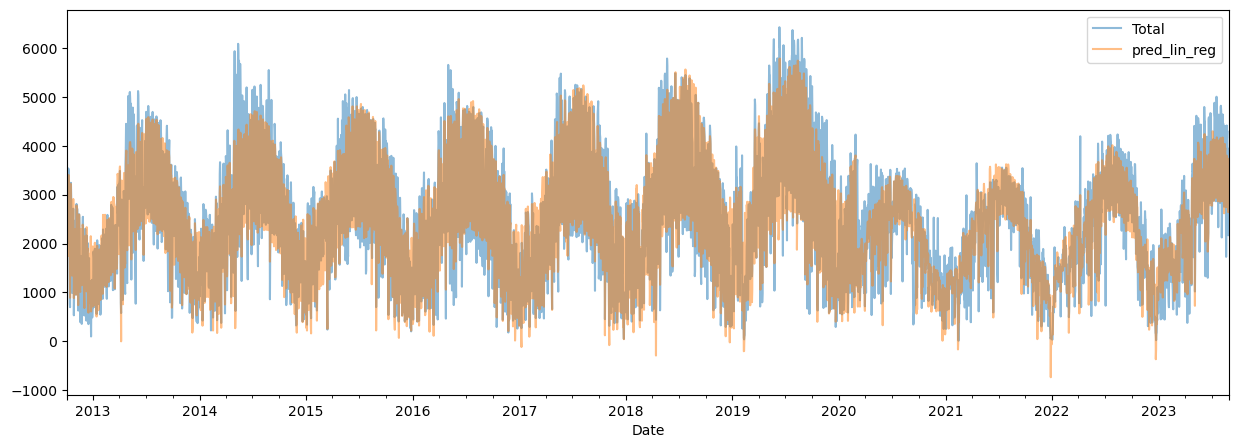

In [49]:
fremont[['Total','pred_lin_reg']].plot(figsize=(15,5), alpha=0.5)

<Axes: xlabel='Date'>

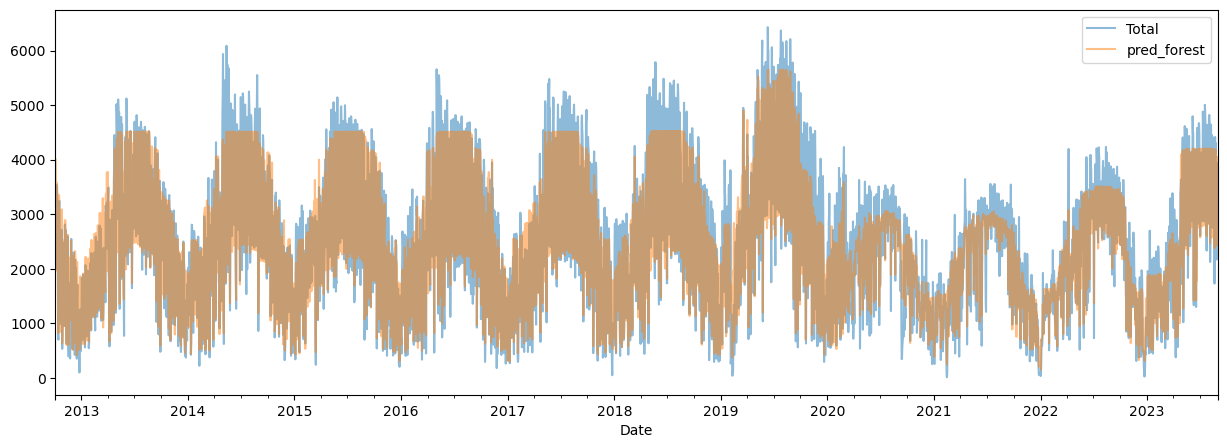

In [50]:
fremont[['Total','pred_forest']].plot(figsize=(15,5), alpha=0.5)

<Axes: xlabel='Date'>

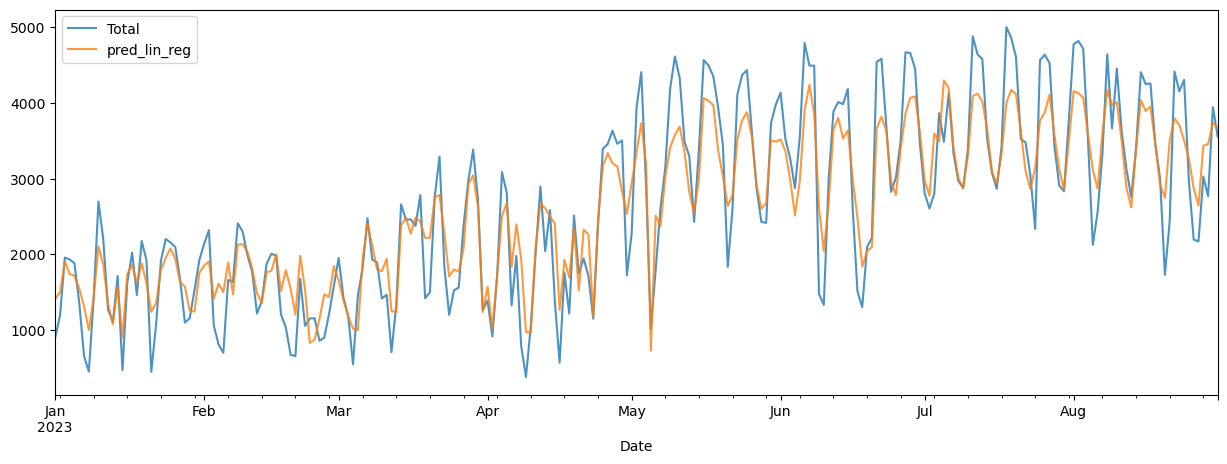

In [53]:
fremont.loc['2023'][['Total','pred_lin_reg']].plot(figsize=(15,5), alpha=0.8)

<Axes: xlabel='Date'>

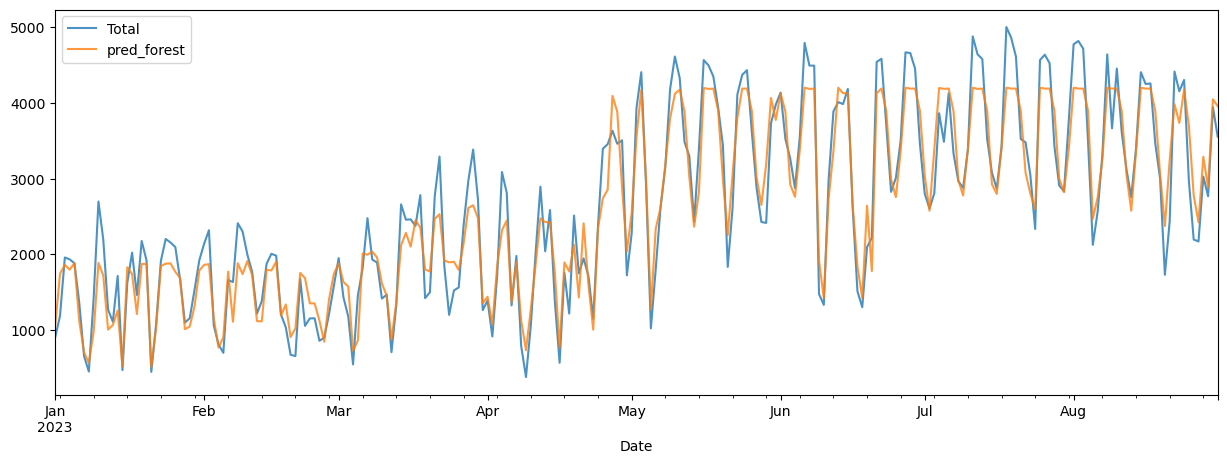

In [54]:
fremont.loc['2023'][['Total','pred_forest']].plot(figsize=(15,5), alpha=0.8)